# Tensorw LFW RNN trainning
To learn how to encode a simple image and a GIF

## Import needed for Jupiter

In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import Image

## Import needed for the code

In [2]:
import numpy as np
import tensorflow as tf

import fnmatch, os
import time

## A function to save a picture

In [3]:
#need to be called within a session
def write_png(tensor, name):
    casted_to_uint8 = tf.cast(tensor, tf.uint8)
    converted_to_png = tf.image.encode_png(casted_to_uint8)
    f = open(name, "wb+")
    f.write(converted_to_png.eval())
    f.close() 

In [4]:
## A class to define all args

In [5]:
class Args():
    def __init__(self):
        '''directory to store checkpointed models'''
        self.save_dir = 'save_face_training'
        
        '''Picture size'''
        self.picture_size = 128
    
        '''size of RNN hidden state'''
        self.rnn_size = 250 
        '''minibatch size'''
        self.batch_size = 1
        '''RNN sequence length'''
        self.seq_length = self.picture_size
        '''number of epochs'''
        self.num_epochs = 10 # was 5
        '''save frequency'''
        self.save_every = 50 # was 500
        '''Print frequency'''
        self.print_every = 10
        '''clip gradients at this value'''
        self.grad_clip = 5.
        '''learning rate'''
        self.learning_rate = 0.002 # was 0.002
        '''decay rate for rmsprop'''
        self.decay_rate = 0.98
        """continue training from saved model at this path.
        Path must contain files saved by previous training process: """
        #self.init_from = 'save_face_training'
        self.init_from = None
        
        '''number of ligne to sample'''
        self.n = 250


In [6]:
class FaceLoader:
    def prepare_reading_faces(self):
        self.matches = []
    
        for root, dirnames, filenames in os.walk('./lfw/'):
            #print filenames
            for filename in fnmatch.filter(filenames, '*.jpg'):
                self.matches.append(os.path.join(root, filename))

        size = len(self.matches)

        filenames = tf.constant(self.matches)
        self.filename_queue = tf.train.string_input_producer(filenames)
        self.image_reader = tf.WholeFileReader()
        return size
    
    def do_when_session(self):   
        # For some reason, we need a coordinator and some threads
        self.coord = tf.train.Coordinator()
        self.threads = tf.train.start_queue_runners(coord=self.coord)

    def stop_reading_faces(self):
        # Finish off the filename queue coordinator.
        self.coord.request_stop()
        self.coord.join(self.threads)
          
    def load_one_face(self, image_size):
        # read and decode image, will give a uint8 with shape [250, 250, 1]
        filename, image_file = self.image_reader.read(self.filename_queue)     
        image = tf.image.decode_jpeg(image_file, channels=1)
        #resize
        image = tf.image.resize_images(image, image_size, image_size)

        # remove channel dimension
        tensor_uint8 = tf.squeeze(image, squeeze_dims=[2])

        # convert to float32 and concat to all face
        tensor = tf.cast(tensor_uint8, tf.float32)
        a_vector_face = tensor/255
        #a_vector_face = (tf.sign(tensor-128)+1)/2
        #print a_vector_face.eval()[0][128]
        a_bw_picture = a_vector_face*255
        
        #write_png(a_bw_picture, 'bw_face.png')
        
        # print some log
        #print(filename.eval(),a_bw_picture.eval().shape)
            
        xdata = a_vector_face.eval()
        ydata = np.copy(xdata)
        ydata[:-1] = xdata[1:]
        ydata[-1] = xdata[0]
        self.x_batches = np.squeeze(np.split(xdata, image_size, 0))
        self.y_batches = np.squeeze(np.split(ydata, image_size, 0))
                
    def next_batch(self):
        return self.x_batches, self.y_batches

In [7]:
tf.reset_default_graph()
faceloader = FaceLoader()
face_count = faceloader.prepare_reading_faces()
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    faceloader.do_when_session()
    faceloader.load_one_face(64)
    x, y = faceloader.next_batch();
    print x, y


[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.00059743 ...,  0.          0.          0.        ]
 ..., 
 [ 0.16801471  0.21397059  0.22182904 ...,  0.24234451  0.21102941
   0.21997549]
 [ 0.22671568  0.21990655  0.23662683 ...,  0.25196078  0.2007353
   0.22057292]
 [ 0.23137255  0.25493643  0.2540288  ...,  0.25735295  0.19453891
   0.23925015]] [[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.00059743 ...,  0.          0.          0.        ]
 [ 0.17757353  0.14338236  0.17376685 ...,  0.12377451  0.13415287
   0.13504902]
 ..., 
 [ 0.22671568  0.21990655  0.23662683 ...,  0.25196078  0.2007353
   0.22057292]
 [ 0.23137255  0.25493643  0.2540288  ...,  0.25735295  0.19453891
   0.23925015]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


In [8]:
class Model():
    def __init__(self, args, infer=False):
        self.args = args
        if infer:
            '''Infer is true when the model is used for sampling'''
            args.seq_length = 1
   
        hidden_size = args.rnn_size
        vector_size = args.picture_size
        
        # define place holder to for the input data and the target.
        self.input_data = tf.placeholder(tf.float32, [ args.seq_length, vector_size], name='input_data')
        self.target_data = tf.placeholder(tf.float32, [ args.seq_length, vector_size], name='target_data') 
        # define the input xs
        xs = tf.split(0, args.seq_length, self.input_data)
        # define the target
        targets = tf.split(0, args.seq_length, self.target_data)  
        #initial_state
        self.initial_state = tf.zeros((hidden_size,1))
        #last_state = tf.placeholder(tf.float32, (hidden_size, 1))
        
        # model parameters
        Wxh = tf.Variable(tf.random_uniform((hidden_size, vector_size))*0.01, name='Wxh') # input to hidden
        Whh = tf.Variable(tf.random_uniform((hidden_size, hidden_size))*0.01, name='Whh') # hidden to hidden
        Why = tf.Variable(tf.random_uniform((vector_size, hidden_size))*0.01, name='Why') # hidden to output
        bh = tf.Variable(tf.zeros((hidden_size, 1)), name='bh') # hidden bias
        by = tf.Variable(tf.zeros((vector_size, 1)), name='by') # output bias
        loss = tf.zeros([1], name='loss')
        
        hs, ys, ps = {}, {}, {}
        
        hs[-1] = self.initial_state
        # forward pass                                                                                                                                                                              
        for t in xrange(args.seq_length):
            xs_t = tf.transpose(xs[t])
            targets_t = tf.transpose(targets[t]) 
            
            hs[t] = tf.sigmoid(tf.matmul(Wxh, xs_t) + tf.matmul(Whh, hs[t-1]) + bh) # hidden state
            #hs[t] = tf.sigmoid(hs[t])
            ys[t] = tf.matmul(Why, hs[t]) + by # unnormalized log probabilities for next line
            ys[t] = tf.sigmoid(ys[t])
            #ps[t] = tf.exp(ys[t]) / tf.reduce_sum(tf.exp(ys[t])) # probabilities for next chars
            #ps[t] = (tf.sign(ys[t]-0.5)+1)/2
            #loss += -tf.log(tf.reduce_sum(tf.abs(ps[t]-targets_t))+0.00000001) # softmax (cross-entropy loss)
            loss += tf.reduce_sum(tf.abs(ys[t]-targets_t))

        self.probs = ys[args.seq_length-1]
        self.cost = loss / args.batch_size / args.seq_length
        self.final_state = hs[args.seq_length-1]
        self.lr = tf.Variable(0.0, trainable=False, name='learning_rate')
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tvars),
                args.grad_clip)
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_op = optimizer.apply_gradients(zip(grads, tvars))

    def sample(self, sess):
        size = self.args.picture_size
        picture_vect = np.zeros((size, size))
        state = model.initial_state.eval()
        x = np.random.random([1, size])
        feed = {self.input_data: x, self.initial_state:state}
        [probs, state] = sess.run([self.probs, self.final_state], feed)
        for n in range(0):
            line = np.transpose(probs)
            feed = {self.input_data: line, self.initial_state:state}
            [probs, state] = sess.run([self.probs, self.final_state], feed)
        for n in range(size):
            line = np.transpose(probs)
            feed = {self.input_data: line, self.initial_state:state}
            [probs, state] = sess.run([self.probs, self.final_state], feed)
            #print probs
            #line = (np.sign(probs-0.5)+1)/2
            #print line
            picture_vect[n] = np.squeeze(line)  
            picture = picture_vect*255
        return tf.expand_dims(picture,2)
    
    def inspect(self, draw=False):
        for var in tf.all_variables():
            if var in tf.trainable_variables():
                print ('t', var.name, var.eval().shape)
                if draw:
                    plt.figure(figsize=(1,1))
                    plt.figimage(var.eval())
                    plt.show()
            else:
                print ('nt', var.name, var.eval().shape)
                
        

## Training

In [9]:
tf.reset_default_graph()
args = Args()
model = Model(args)
print ("model created")
faceloader = FaceLoader()
face_count = faceloader.prepare_reading_faces()
print ('faces count', face_count)

cost_optimisation = []

with tf.Session() as sess:
    tf.initialize_all_variables().run()
    print ("variable initialized")
    faceloader.do_when_session()
    saver = tf.train.Saver(tf.all_variables())

    # restore model
    if args.init_from is not None:
        ckpt = tf.train.get_checkpoint_state(args.init_from)
        assert ckpt,"No checkpoint found"
        assert ckpt.model_checkpoint_path,"No model path found in checkpoint"
        saver.restore(sess, ckpt.model_checkpoint_path)
        print ("model restored")
    for e in range(args.num_epochs):
        faceloader.image_reader.reset()
        sess.run(tf.assign(model.lr, args.learning_rate * (args.decay_rate ** e)))
        state = model.initial_state.eval()
        for b in range(face_count):
            start = time.time()
            # Get learning data
            faceloader.load_one_face(args.picture_size)
            x, y = faceloader.next_batch()
            # Create the structure for the learning data
            feed = {model.input_data: x, model.target_data: y, model.initial_state: state}
            # Run a session using train_op
            [train_loss], state, _ = sess.run([model.cost, model.final_state, model.train_op], feed)
            end = time.time()
            if (e * face_count + b) % args.print_every == 0:
                cost_optimisation.append(train_loss)
                print("{}/{} (epoch {}), train_loss = {:.6f}, time/batch = {:.3f}" \
                    .format(e * face_count + b,
                            args.num_epochs * face_count,
                            e, train_loss, end - start))
            if (e * face_count + b) % args.save_every == 0:
                checkpoint_path = os.path.join(args.save_dir, 'model.ckpt')
                saver.save(sess, checkpoint_path, global_step = e * face_count + b)
                print("model saved to {}".format(checkpoint_path))
                np.save('cost', cost_optimisation)


model created
('faces count', 13233)
variable initialized
0/132330 (epoch 0), train_loss = 146.003983, time/batch = 2.277
model saved to save_face_training/model.ckpt
100/132330 (epoch 0), train_loss = 36.013523, time/batch = 1.237
200/132330 (epoch 0), train_loss = 42.699650, time/batch = 1.704
300/132330 (epoch 0), train_loss = 40.892017, time/batch = 1.392
400/132330 (epoch 0), train_loss = 24.033468, time/batch = 1.479
500/132330 (epoch 0), train_loss = 21.329237, time/batch = 1.562
model saved to save_face_training/model.ckpt


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


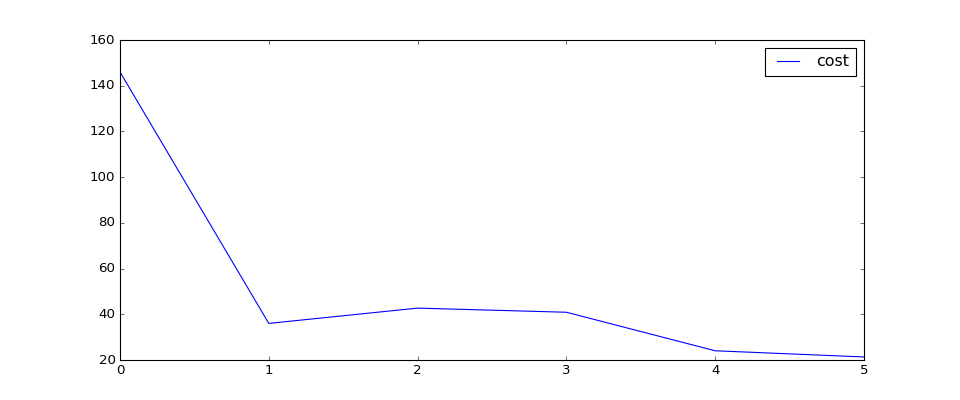

In [10]:
cost_optimisation = np.load('cost.npy')
plt.figure(figsize=(12,5))
plt.plot(range(len(cost_optimisation)), cost_optimisation, label='cost')
plt.legend()
plt.show()

model_checkpoint_path: "save_face_training/model.ckpt-500"
all_model_checkpoint_paths: "save_face_training/model.ckpt-0"
all_model_checkpoint_paths: "save_face_training/model.ckpt-500"

('t', u'Wxh:0', (500, 250))


<IPython.core.display.Javascript object>


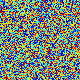

('t', u'Whh:0', (500, 500))


<IPython.core.display.Javascript object>


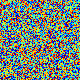

('t', u'Why:0', (250, 500))


<IPython.core.display.Javascript object>


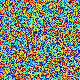

('t', u'bh:0', (500, 1))


<IPython.core.display.Javascript object>


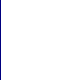

('t', u'by:0', (250, 1))


<IPython.core.display.Javascript object>


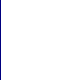

('nt', u'learning_rate:0', ())
('nt', u'beta1_power:0', ())
('nt', u'beta2_power:0', ())
('nt', u'Wxh/Adam:0', (500, 250))
('nt', u'Wxh/Adam_1:0', (500, 250))
('nt', u'Whh/Adam:0', (500, 500))
('nt', u'Whh/Adam_1:0', (500, 500))
('nt', u'Why/Adam:0', (250, 500))
('nt', u'Why/Adam_1:0', (250, 500))
('nt', u'bh/Adam:0', (500, 1))
('nt', u'bh/Adam_1:0', (500, 1))
('nt', u'by/Adam:0', (250, 1))
('nt', u'by/Adam_1:0', (250, 1))


In [11]:
tf.reset_default_graph()
args = Args()
model = Model(args, True)  # True to generate the model in sampling mode
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    saver = tf.train.Saver(tf.all_variables())
    ckpt = tf.train.get_checkpoint_state(args.save_dir)
    print (ckpt)
    
    model.inspect(draw=True)

## sampling

In [12]:
tf.reset_default_graph()
args = Args()
model = Model(args, infer=True)
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    print 'intialisation done'
    saver = tf.train.Saver(tf.all_variables())
    ckpt = tf.train.get_checkpoint_state(args.save_dir)
    print (ckpt)
    
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        pict = model.sample(sess)
        print(pict.eval().ravel())
        write_png(pict, 'a_face.png')

intialisation done
model_checkpoint_path: "save_face_training/model.ckpt-500"
all_model_checkpoint_paths: "save_face_training/model.ckpt-0"
all_model_checkpoint_paths: "save_face_training/model.ckpt-500"

[ 133.10106665  135.15171021  136.12614512 ...,  208.89012784  207.86448687
  206.72380328]


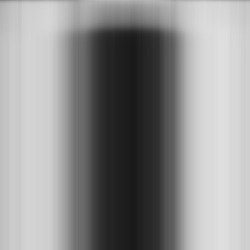

In [13]:
Image("a_face.png")

Feedback wellcome @dh7net